In [1]:
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import differential_evolution

n = 100

## Пункт а

##### Хи квадрат

In [ ]:
pval = float(1 - st.chi2.cdf(16.4, 9))
print(f"{pval = }")

chi2_pval = 0.058984030544419475


##### Колмогоров

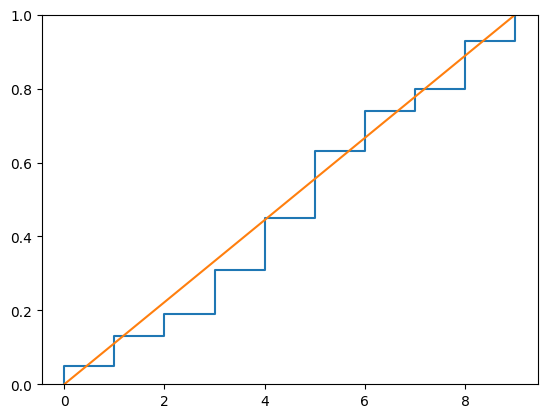

In [18]:
count = [5, 8, 6, 12, 14, 18, 11, 6, 13, 7]
data = []
for i in range(len(count)):
    data += [i]*count[i]

x = np.linspace(0, 9, 10)
ecdf = np.append([0], st.ecdf(data).cdf.probabilities)
cdf = st.uniform.cdf(x, loc=0, scale=9)

plt.ecdf(data)
plt.plot(x, cdf)

In [26]:
kolmogorov_delta = np.sqrt(n) * np.max(np.abs(
    np.append(
        cdf - ecdf[:10],
        cdf - ecdf[1:]
    )
))
kolmogorov_pval = 0
for i in range(1, 100_000):
    kolmogorov_pval += 2 * ((-1)**(i + 1)) * np.exp(-2 * (i**2) * (kolmogorov_delta**2))
print(f"delta - {kolmogorov_delta}\np_value - {kolmogorov_pval}")

delta - 1.4333333333333331
p_value - 0.03285188543859743


## Пункт b

##### Хи квадрат

In [29]:
m_i = [5, 8, 6, 12, 14, 18, 11, 6, 13, 7]

def func(x):
    global m_i
    
    loc = x[0]
    scale = x[1]

    p_i = st.norm.cdf([1, 2, 3, 4, 5, 6, 7, 8, 9], loc=loc, scale=scale)
    product = 1
    for i in range(8):
        product *= (p_i[i + 1] - p_i[i]) ** m_i[i + 1]

    return - (p_i[0] ** m_i[0] * (1 - p_i[-1]) ** m_i[-1] * product)


res = differential_evolution(
    func=func,
    bounds=[(3, 7), (1, 4)],
    maxiter=10_000,
)

theta_1 = float(res.x[0])
theta_2 = float(res.x[1])

p_i = st.norm.cdf([1, 2, 3, 4, 5, 6, 7, 8, 9], loc=theta_1, scale=theta_2)

np_i = []
np_i.append(n * p_i[0])
for i in range(8):
    np_i.append(n * (p_i[i + 1] - p_i[i]))
np_i.append(n * (1 - p_i[-1]))

np_i = np.array(np_i)

print(f"theta_1 - {theta_1}\ntheta_2 - {theta_2}")

theta_1 - 5.291625134170802
theta_2 - 2.6831542881348347


In [28]:
delta = float(np.sum((np_i - m_i) ** 2 / np_i))
pval = float(1 - st.chi2.cdf(delta, 7))

print(f"delta - {delta}\np_value - {pval}")

delta - 9.814605978898538
p_value - 0.19932528634485946


##### Колмогоров

In [30]:
def parametric_bootstrap(data, statistic, prob_model, n_resamples = 10_000):
    n = len(data)
    bootstrap_data = np.ndarray((n_resamples, ), dtype=np.float32)

    for i in range(n_resamples):
        resample = prob_model(n)
        bootstrap_data[i] = statistic(resample)
    
    bootstrap_data.sort()

    return bootstrap_data


def statistic(data):
    data = np.sort(data)

    mean = np.mean(data)
    std = np.std(data, ddof=1)

    ecdf = np.append([0], st.ecdf(data).cdf.probabilities)
    cdf = st.norm.cdf(data, loc=mean, scale=std)
    delta = np.sqrt(n) * np.max(np.abs(
        np.append(
            cdf - ecdf[:len(ecdf) - 1],
            cdf - ecdf[1:]
        )
    ))

    return delta


mean = np.mean(data)
std = np.std(data, ddof=1)
n_resamples = 50_000
bootstrap = parametric_bootstrap(data, statistic, lambda n: np.random.normal(mean, std, n), n_resamples=n_resamples)

x = np.linspace(0, 9, 10)
ecdf = np.append([0], st.ecdf(data).cdf.probabilities)
cdf = st.norm.cdf(x, loc=mean, scale=std)
kolmogorov_delta = np.sqrt(n) * np.max(np.abs(
    np.append(
        cdf - ecdf[:10],
        cdf - ecdf[1:]
    )
))
kolmogorov_delta = float(kolmogorov_delta)

kolmogorov_pval = np.count_nonzero(bootstrap >= kolmogorov_delta) / n_resamples

print(
    f"{kolmogorov_delta = }",
    f"{kolmogorov_pval = }",
    sep="\n"
)

kolmogorov_delta = 1.0020942299329128
kolmogorov_pval = 0.0144
